In [1]:
# Librerías
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#scipy.spatial.distance.cdist
from gensim.models import Word2Vec
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Valores de prueba

In [2]:
tiempo_ejecucion = 0
tamanos_muestras = [10, 50, 100, 500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]
regs_prueba = pd.read_csv('Data/items_titles.csv'
                          , encoding = 'UTF-8'
                          ).sample(10, random_state = 624)['ITE_ITEM_TITLE'].str.strip().to_list()

## Word Embeddings

In [3]:
def similitud_word_embedding(item, ruta_entrada = 'Data/items_titles.csv', n = 0, top = 2):
    start_time = time.time()
    #Muestra
    items_df = pd.read_csv(ruta_entrada
                           , encoding = 'UTF-8'
                           )
    items_df['ITE_ITEM_TITLE'] = items_df['ITE_ITEM_TITLE'].str.strip()
    items_necesario_df = items_df[items_df['ITE_ITEM_TITLE']==item]
    items_df = items_df.sample(len(items_df) if n == 0 else n)
    items_df = pd.concat([items_df, items_necesario_df]).drop_duplicates().reset_index(drop=True)
    
    # Generar columna de texto procesado
    items_df['processed_titles'] = items_df['ITE_ITEM_TITLE'].str.lower().str.replace('[^\w\s]', '', regex=True)
    
    # Pasar elementos de la oración a listas
    items_df['processed_titles_list'] = items_df['processed_titles'].str.split()
    items_list = items_df['processed_titles_list'].to_list()
    
    # Generacion de modelo
    modelo = Word2Vec(items_df['processed_titles'].tolist()
                      , vector_size=100
                      , window=7
                      , min_count=5
                      , workers=12
                     )
    
    # Mapear vector para cada item
    items_df['vector'] = items_df['processed_titles'].apply(lambda x: np.mean([modelo.wv[word] for word in x if word in modelo.wv], axis=0))
    vectors = np.stack(items_df['vector'].values)
    
    # Calcular la matriz de similitud del coseno
    cosine_sim_matrix = cosine_similarity(vectors)
    
    # Obtener dataframe de simulitudes entre productos
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=items_df[items_df.columns[0]], columns=items_df[items_df.columns[0]])
    
    # Devolver top de valores necesarios
    df_respuesta = pd.DataFrame(cosine_sim_df[item].sort_values(ascending=False)[1:top+1]).reset_index().rename(columns={'ITE_ITEM_TITLE':'ITE_ITEM_TITLE_2'
                                                                                                                        ,f'{item}':'SCORE_SIMILITUD'
                                                                                                                        }
                                                                                                               )
    df_respuesta['ITE_ITEM_TITLE_1'] = item
    df_respuesta = df_respuesta[['ITE_ITEM_TITLE_1', 'ITE_ITEM_TITLE_2', 'SCORE_SIMILITUD']]
    end_time = time.time()
    
    return(df_respuesta, (end_time - start_time))

In [4]:
df_rendimiento = pd.DataFrame(columns=['modelo', 'tamano_muestra', 'tiempo', 'std_tiempo'])
for i in tamanos_muestras:
    tiempos = []
    for j in regs_prueba:
        tiempos = tiempos + [similitud_word_embedding(item = j, n = i)[1]]
    df_rendimiento = pd.concat([df_rendimiento
                                , pd.DataFrame({'modelo':['Word Embedding']
                                                , 'tamano_muestra':[int(i)]
                                                , 'tiempo':[np.mean(tiempos)]
                                                , 'std_tiempo':[np.std(tiempos)]
                                               }
                                              )
                               ]
                               , axis = 0
                              ).reset_index(drop=True)

## TF-IDF

In [5]:
def similitud_td_idf(item, ruta_entrada = 'Data/items_titles.csv', n = 0, top = 2):
    start_time = time.time()
    #Muestra
    items_df = pd.read_csv(ruta_entrada
                           , encoding = 'UTF-8'
                           )
    items_df['ITE_ITEM_TITLE'] = items_df['ITE_ITEM_TITLE'].str.strip()
    items_necesario_df = items_df[items_df['ITE_ITEM_TITLE']==item]
    items_df = items_df.sample(len(items_df) if n == 0 else n)
    items_df = pd.concat([items_df, items_necesario_df]).drop_duplicates()

    # Generar columna de texto procesado
    items_df['processed_titles'] = items_df['ITE_ITEM_TITLE'].str.lower().str.replace('[^\w\s]', '', regex=True)
    
    # Vectorización TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(items_df['processed_titles'])
    
    # Calcular la matriz de similitud del coseno
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)
    
    # Obtener dataframe de simulitudes entre productos
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=items_df[items_df.columns[0]], columns=items_df[items_df.columns[0]])
    
    # Devolver top de valores necesarios
    df_respuesta = pd.DataFrame(cosine_sim_df[item].sort_values(ascending=False)[1:top+1]).reset_index().rename(columns={'ITE_ITEM_TITLE':'ITE_ITEM_TITLE_2'
                                                                                                                        ,f'{item}':'SCORE_SIMILITUD'
                                                                                                                        }
                                                                                                               )
    df_respuesta['ITE_ITEM_TITLE_1'] = item
    df_respuesta = df_respuesta[['ITE_ITEM_TITLE_1', 'ITE_ITEM_TITLE_2', 'SCORE_SIMILITUD']]
    end_time = time.time()

    return(df_respuesta, (end_time - start_time))

In [6]:
for i in tamanos_muestras:
    tiempos = []
    for j in regs_prueba:
        tiempos = tiempos + [similitud_td_idf(item = j, n = i)[1]]
    df_rendimiento = pd.concat([df_rendimiento
                                , pd.DataFrame({'modelo':['TD-IDF']
                                                , 'tamano_muestra':[int(i)]
                                                , 'tiempo':[np.mean(tiempos)]
                                                , 'std_tiempo':[np.std(tiempos)]
                                               }
                                              )
                               ]
                               , axis = 0
                              ).reset_index(drop=True)

## Escalamiento

In [7]:
df_rendimiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   modelo          22 non-null     object 
 1   tamano_muestra  22 non-null     object 
 2   tiempo          22 non-null     float64
 3   std_tiempo      22 non-null     float64
dtypes: float64(2), object(2)
memory usage: 836.0+ bytes


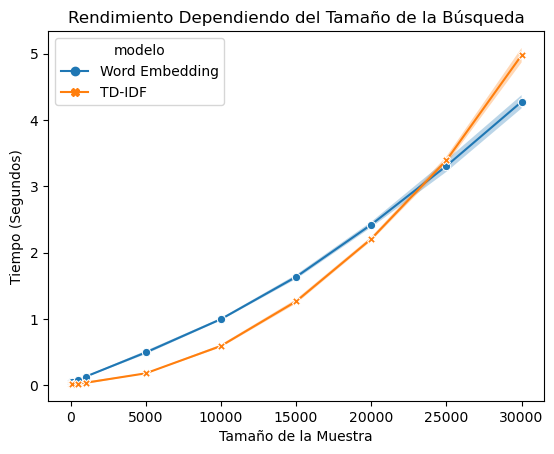

In [8]:
df_rendimiento['tamano_muestra'] = pd.to_numeric(df_rendimiento['tamano_muestra'])
ax = sns.lineplot(data=df_rendimiento,
                  x='tamano_muestra',
                  y='tiempo',
                  hue='modelo',
                  style='modelo',
                  markers=True,
                  dashes=False)

# Sombreado desvest

for modelo in ['Word Embedding', 'TD-IDF']:
    df_subset = df_rendimiento[df_rendimiento['modelo'] == modelo]
    x = df_subset['tamano_muestra']
    y = df_subset['tiempo']
    sigma = df_subset['std_tiempo']
    lower_bound = y - sigma
    upper_bound = y + sigma
    
    ax.fill_between(x, lower_bound, upper_bound, alpha=0.3)

# Añadir títulos y etiquetas
ax.set_title('Rendimiento Dependiendo del Tamaño de la Búsqueda')
ax.set_ylabel('Tiempo (Segundos)')
ax.set_xlabel('Tamaño de la Muestra')

# Mostrar el gráfico
plt.show()

## Herramienta para testeo

In [9]:
%%time
resultado = similitud_td_idf(item = 'Sapatênis 45116 Levecomfort Em Couro'
                             , ruta_entrada = 'Data/items_titles_test.csv'
                             , top = 2
                            )[0]

resultado

CPU times: total: 719 ms
Wall time: 769 ms


,ITE_ITEM_TITLE_1,ITE_ITEM_TITLE_2,SCORE_SIMILITUD
0,Sapatênis 45116 Levecomfort Em Couro,Sapatênis Masculino Ranster Casual Em Couro,0.312492
1,Sapatênis 45116 Levecomfort Em Couro,Tênis Casual Em Couro Branco,0.302007


In [10]:
%%time
resultado = similitud_word_embedding(item = 'Sapatênis 45116 Levecomfort Em Couro'
                                     , ruta_entrada = 'Data/items_titles_test.csv'
                                     , top = 2
                                    )[0]

resultado

CPU times: total: 2.8 s
Wall time: 1.12 s


,ITE_ITEM_TITLE_1,ITE_ITEM_TITLE_2,SCORE_SIMILITUD
0,Sapatênis 45116 Levecomfort Em Couro,Tênis Casual Feminino Comfortflex Com Textura ...,0.982361
1,Sapatênis 45116 Levecomfort Em Couro,Tênis Pegada Em Couro Feminino Flatform - Crem...,0.981387
